In [1]:
from langgraph.prebuilt import create_react_agent
from langchain_ollama import ChatOllama
from ddgs import DDGS
import ast
import operator
import time  
from langchain_core.tools import tool, Tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import PromptTemplate
from langgraph.prebuilt import create_react_agent
from langchain import hub


In [2]:
#llm  = ChatOllama(model="deepseek-r1:8b")
#llm  = ChatOllama(model="llama3.2:3b")
llm  = ChatOllama(model="llama3.1:8b")

In [3]:
@tool
def calculator(expression: str) -> str:
    """Calculator for mathematical expressions. Input: mathematical expression like '2+2' or 'abs(-5)'"""
    try:
        # Safe expression evaluator using AST
        def safe_eval(node):
            if isinstance(node, ast.Constant):
                return node.value
            elif isinstance(node, ast.BinOp):
                left = safe_eval(node.left)
                right = safe_eval(node.right)
                return {
                    ast.Add: operator.add,
                    ast.Sub: operator.sub,
                    ast.Mult: operator.mul,
                    ast.Div: operator.truediv,
                    ast.Pow: operator.pow,
                    ast.Mod: operator.mod,
                }[type(node.op)](left, right)
            elif isinstance(node, ast.UnaryOp):
                operand = safe_eval(node.operand)
                return {
                    ast.UAdd: operator.pos,
                    ast.USub: operator.neg,
                }[type(node.op)](operand)
            elif isinstance(node, ast.Call):
                func_name = node.func.id
                args = [safe_eval(arg) for arg in node.args]
                
                # Safe math functions
                safe_functions = {
                    'abs': abs,
                    'round': round,
                    'sqrt': math.sqrt,
                    'sin': math.sin,
                    'cos': math.cos,
                    'tan': math.tan,
                    'log': math.log,
                    'log10': math.log10,
                    'exp': math.exp,
                    'floor': math.floor,
                    'ceil': math.ceil,
                }
                
                if func_name in safe_functions:
                    return safe_functions[func_name](*args)
                else:
                    raise ValueError(f"Function {func_name} not allowed")
            elif isinstance(node, ast.Name):
                # Allow mathematical constants
                constants = {
                    'pi': math.pi,
                    'e': math.e,
                }
                if node.id in constants:
                    return constants[node.id]
                else:
                    raise ValueError(f"Variable {node.id} not allowed")
            else:
                raise ValueError(f"Operation {type(node)} not supported")
        
        # Parse and evaluate
        parsed = ast.parse(expression, mode='eval')
        result = safe_eval(parsed.body)
        return str(result)
        
    except Exception as e:
        return f"Math error: {str(e)}"

In [4]:
@tool
def ddg_search(query: str) -> str:
    """Search DuckDuckGo for current information. Input: search query string"""
    try:
        # Retry logic to handle transient issues, know issue
        results = None
        RETRY_COUNT = 5
        for i in range(RETRY_COUNT):
            with DDGS() as ddgs:
                results = ddgs.text(query, max_results=3)
            
            if results is not None and len(results) > 0:
                break
            time.sleep(1)

        if not results:
            return "No search results found"
            
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"{i}. {result.get('title', 'No title')}\n"
                f"   {result.get('body', 'No description')}\n"
                f"   URL: {result.get('href', 'No URL')}"
            )
        
        return "\n\n".join(formatted_results)
    except Exception as e:
        return f"Search error: {str(e)}"


In [5]:
@tool
def get_weather(location: str) -> str:
    """Get weather information for a location."""
    # This is a mock function - in reality you'd call a weather API
    return f"The weather in {location} is sunny with a temperature of 72°F"

In [6]:
@tool
def word_count(text: str) -> str:
    """Count the number of words in a text."""
    words = len(text.split())
    return f"Word count: {words}"

In [7]:
tools = [
    Tool(
        name="get_weather",
        func=get_weather,
        description="Get weather information for a location. Input: location name like 'New York' or 'London'"
    ),
    Tool(
        name="word_count",
        func=word_count,
        description="Count the number of words in a text. Input: word like 'I am good' or 'Hello World' (it will return 'Word count: 3' or 'Word count: 2' respectively'"
   ),
    Tool(
        name="calculator",
        func=calculator,
        description="Calculator for mathematical expressions. Input: mathematical expression like '2+2' or 'abs(-5)'"
    ),
    Tool(
        name="ddg_search",
        func=ddg_search,
        description="Search DuckDuckGo (WEB Serach) for current information. Input: search query string"
    )
]
tool_node = ToolNode(tools)

In [8]:
agent = create_react_agent(llm, tools)

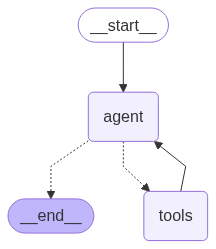

In [9]:
agent

In [10]:
def run_langgraph_agent(question: str) -> str:
    """Run the LangGraph ReACT agent"""
    try:
        initial_state = {
                "messages": [HumanMessage(content=question)],
                "next_action": "start",
                "tool_calls": [],
                "iterations": 0
        }
        
        result = agent.invoke(initial_state)
        
        print("!"*50)
        print(result)
        print("!"*50)

        # Extract final answer
        final_message = result["messages"][-1].content
        if "Final Answer:" in final_message:
            return final_message.split("Final Answer:")[-1].strip()
        return final_message
        
    except Exception as e:
        return f"Error: {str(e)}"

In [11]:
questions = [
        "Calculate 5 * 8 and then count words in 'The quick brown fox'. After that sum both the results. find the weather in San Francisco and add the pemperture with previous sum.",
        "What is (5 + 7) ?",
        "Calculate 15 * 8 and then count words in 'The quick brown fox",
        "Calculate 5 * 8 and then count words in 'The quick brown fox. After that sum both the results'",
        "Calculate 5 * 8 and then count words in 'The quick brown fox.  Then search the web with that final sum'",
        "Search for latest AI developments in 2025",
        "Find recent news about LangChain framework",
        "Calculate -7.5 * 4",
        "What is 25 * 4 + 10?",
        "What's the weather like in San Francisco?",
        "How many words are in 'Hello world from LangGraph'?"
    ]
    
    
for i, question in enumerate(questions, 1):
    print(f"\n{i}. {question}")
    print("-" * 30)
    
    answer = run_langgraph_agent(question)
    print(f"Answer: {answer}")
    print("-" * 50)


1. Calculate 5 * 8 and then count words in 'The quick brown fox'. After that sum both the results. find the weather in San Francisco and add the pemperture with previous sum.
------------------------------
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
{'messages': [HumanMessage(content="Calculate 5 * 8 and then count words in 'The quick brown fox'. After that sum both the results. find the weather in San Francisco and add the pemperture with previous sum.", additional_kwargs={}, response_metadata={}, id='a5afe2ca-1e14-4d0f-b48b-5745e1113e1c'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-07-15T19:16:52.7096321Z', 'done': True, 'done_reason': 'stop', 'total_duration': 44351315300, 'load_duration': 51425400, 'prompt_eval_count': 422, 'prompt_eval_duration': 6010241200, 'eval_count': 112, 'eval_duration': 21601289300, 'model_name': 'llama3.1:8b'}, id='run--69664572-76a1-4f86-be63-8f5322ce3672-0', tool_calls=[{'name': 'cal